In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!echo $HF_HOME

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/hf/misc


In [3]:
import os
from os.path import join
import torch
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
import sys
sys.path.append("/n/home12/hjkim/Github/DiffusionObjectRelation/PixArt-alpha")

from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/hjkim/Github/DiffusionObjectRelation/utils")
from pixart_utils import state_dict_convert
from image_utils import pil_images_to_grid
from pixart_utils import state_dict_convert
from pixart_sampling_utils import PixArtAlphaPipeline_custom, visualize_prompts_with_traj
from pixart_utils import construct_diffuser_transformer_from_config, construct_diffuser_pipeline_from_config


/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


### Load the model

In [4]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"

config = read_config(join(savedir, 'config.py'))

weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()

transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

2025-06-26 10:37:00,453 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.


In [5]:
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))

/tmp/ipykernel_3136395/1495998778.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))


<All keys matched successfully>

In [6]:
model

PixArt(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(4, 768, kernel_size=(2, 2), stride=(2, 2))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=768, bias=True)
      (1): SiLU()
      (2): Linear(in_features=768, out_features=768, bias=True)
    )
  )
  (t_block): Sequential(
    (0): SiLU()
    (1): Linear(in_features=768, out_features=4608, bias=True)
  )
  (y_embedder): CaptionEmbedder(
    (y_proj): Mlp(
      (fc1): Linear(in_features=4096, out_features=768, bias=True)
      (act): GELU(approximate='tanh')
      (drop1): Dropout(p=0, inplace=False)
      (norm): Identity()
      (fc2): Linear(in_features=768, out_features=768, bias=True)
      (drop2): Dropout(p=0, inplace=False)
    )
  )
  (blocks): ModuleList(
    (0-11): 12 x PixArtBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn): WindowAttention(
        (qkv): Linear(in_features=768, out_features=230

## Load the model

In [ ]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"


config = read_config(join(savedir, 'config.py'))

weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()

transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema'])) # model.state_dict()

2025-06-26 10:42:37,600 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_3136395/4255857047.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have ful

<All keys matched successfully>

In [8]:
validation_prompts = config.validation_prompts
prompt_cache_dir = config.prompt_cache_dir
img_per_prompt = 25
sequence_length = config.model_max_length
prompt_index = 5
image_logs_sel, latents_traj_sel, pred_traj_sel, t_traj_sel = visualize_prompts_with_traj        (pipeline, validation_prompts[prompt_index:prompt_index+1], prompt_cache_dir, config.model_max_length, weight_dtype)

/n/home12/hjkim/Github/DiffusionObjectRelation/utils/pixart_sampling_utils.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  uncond_data = torch.load(f'{prompt_cache_dir

torch.Size([50, 20, 4096])
torch.Size([50, 20])


In [9]:
validation_prompts

['triangle is to the upper left of square',
 'blue triangle is to the upper left of red square',
 'triangle is above and to the right of square',
 'blue circle is above and to the right of blue square',
 'triangle is to the left of square',
 'triangle is to the left of triangle',
 'circle is below red square',
 'red circle is to the left of blue square',
 'blue square is to the right of red circle',
 'red circle is above square',
 'triangle is above red circle',
 'red is above blue',
 'red is to the left of red',
 'blue triangle is above red triangle',
 'blue circle is above blue square']

In [10]:
validation_prompts[prompt_index:prompt_index+1]

['triangle is to the left of triangle']

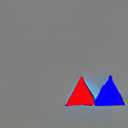

In [11]:
image_logs_sel[0]['images'][0]

In [12]:
pipeline.transformer

Transformer2DModel(
  (pos_embed): PatchEmbed(
    (proj): Conv2d(4, 768, kernel_size=(2, 2), stride=(2, 2))
  )
  (transformer_blocks): ModuleList(
    (0-11): 12 x BasicTransformerBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn1): Attention(
        (to_q): Linear(in_features=768, out_features=768, bias=True)
        (to_k): Linear(in_features=768, out_features=768, bias=True)
        (to_v): Linear(in_features=768, out_features=768, bias=True)
        (to_out): ModuleList(
          (0): Linear(in_features=768, out_features=768, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn2): Attention(
        (to_q): Linear(in_features=768, out_features=768, bias=True)
        (to_k): Linear(in_features=768, out_features=768, bias=True)
        (to_v): Linear(in_features=768, out_features=768, bias=True)
        (to_out): ModuleList(
          (0):

### Define PixArt model from scratch

In [13]:
import math
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

### Patch embedding

In [14]:
# Patch Embedding

class PatchEmbeddingScratch(nn.Module):
    def __init__(self, in_channels, out_channels, patch_size=2):
        super().__init__()
        self.proj = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=(patch_size, patch_size), 
                              stride=(patch_size, patch_size), padding=0)
        
    def forward(self, x):
        patch_proj = self.proj(x)
        patch_proj = rearrange(patch_proj, "b c h w -> b (h w) c")
        return patch_proj

In [15]:
def test_patch_embedding(model):
    proj = PatchEmbeddingScratch(in_channels=4, out_channels=768, patch_size=2)
    proj.load_state_dict(model.x_embedder.state_dict())
    with torch.no_grad():
        tmp_state = torch.randn(5, 4, 16, 16)
        print(proj(tmp_state).shape)
        print(model.x_embedder(tmp_state).shape)
        assert torch.allclose(proj(tmp_state), model.x_embedder(tmp_state))

In [16]:
test_patch_embedding(model)

torch.Size([5, 64, 768])
torch.Size([5, 64, 768])


### Patch Position Embedding

In [17]:
# Position Embedding

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    half_dim = embed_dim // 2
    omega = np.arange(half_dim, dtype=np.float64) / half_dim
    omega = 1. / 10000 ** omega  # (D/2,)
    pos = pos.reshape(-1)  # (M,)
    args = pos[:, None] * omega[None, :]  # (M, D/2), outer product
    return np.concatenate([np.sin(args), np.cos(args)], axis=1)


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    return np.concatenate([emb_h, emb_w], axis=1)


def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False, extra_tokens=0, lewei_scale=1.0, base_size=8):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    if isinstance(grid_size, int):
        grid_size = (grid_size, grid_size)
    
    grid_h = np.arange(grid_size[0], dtype=np.float32) / (grid_size[0] / base_size) / lewei_scale # note this is basically np.arange(grid_size[0]), remove the base_size which should be the same as the grid_size. 
    grid_w = np.arange(grid_size[1], dtype=np.float32) / (grid_size[1] / base_size) / lewei_scale
    grid = np.meshgrid(grid_w, grid_h)  # here x coordinate goes first, y coordinate goes second
    grid = np.stack(grid, axis=0)
    grid = grid.reshape([2, grid_size[1], grid_size[0]])

    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token and extra_tokens > 0:
        pos_embed = np.concatenate([np.zeros([extra_tokens, embed_dim]), pos_embed], axis=0)
    return pos_embed

In [18]:
def test_pos_embed(model):
    pos_embed = get_2d_sincos_pos_embed(768, (8, 8))
    print(pos_embed.shape)
    assert torch.allclose(torch.tensor(pos_embed).to(torch.float32), 
                        model.pos_embed[0]), "Position embedding does not match"

test_pos_embed(model)


(64, 768)


#### Visualize patch position embedding

In [19]:
print(model.pos_embed.shape)
print(model.pos_embed)

torch.Size([1, 64, 768])
tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.8415,  0.8153,  0.7886,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.9093,  0.9442,  0.9698,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.9589, -0.9986, -0.9856,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2794, -0.5348, -0.7393,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.6570,  0.3792,  0.0764,  ...,  1.0000,  1.0000,  1.0000]]])


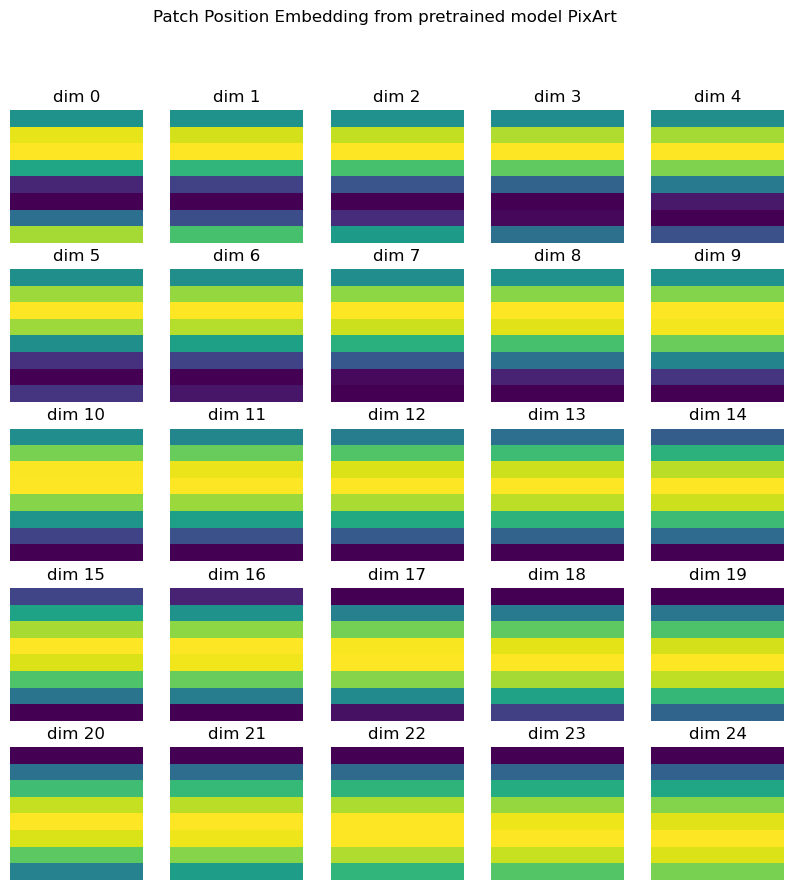

In [20]:
figh, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()
for i in range(25):
    axs[i].imshow(model.pos_embed.reshape(8, 8, 768).\
                detach().cpu().numpy()[:, :, 384+i])
    axs[i].set_title(f"dim {i}")
    axs[i].axis("off")
plt.suptitle("Patch Position Embedding from pretrained model PixArt")
plt.show()

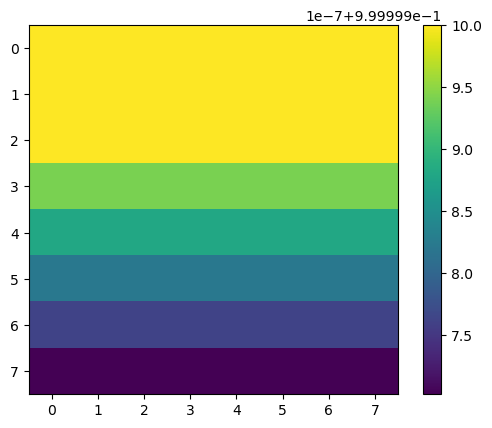

In [21]:
plt.imshow(model.pos_embed.reshape(8, 8, 768).\
            detach().cpu().numpy()[:, :, -2])
plt.colorbar()
plt.show()

### Time step embedding

In [22]:
# Time Embedding

def get_sinusoidal_embedding(t, dim, max_period=10000, device="cpu"):
    half = dim // 2
    # freqs = torch.float_power(max_period, -torch.arange(start=0, end=half, dtype=torch.float32, device=device) / half).to(torch.float32)
    freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32, device=device) / half)
    args = t[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        # in case the dimension is odd, add a zero embedding for the last dimension
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class TimeEmbeddingScratch(nn.Module):
    def __init__(self, hidden_dim, freq_embedding_size=256, max_period=10000):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.mlp = nn.Sequential(
            nn.Linear(freq_embedding_size, hidden_dim, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim, bias=True),
        )
        self.freq_embedding_size = freq_embedding_size
        self.max_period = max_period
        
    def forward(self, t):
        sin_emb = get_sinusoidal_embedding(t, self.freq_embedding_size, self.max_period, device=t.device) #.to(self.dtype)
        return self.mlp(sin_emb)
    

def get_time_blocks(hidden_size):
    return nn.Sequential(
        nn.SiLU(),
        nn.Linear(hidden_size, hidden_size * 6, bias=True),
    )

In [23]:
def test_time_blocks(model):
    t_blocks = get_time_blocks(768)
    # Test the time embedding
    t_blocks.load_state_dict(model.t_block.state_dict())
    tmp_state = torch.randn(5, 768)
    assert torch.allclose(t_blocks(tmp_state), model.t_block(tmp_state))
    
    
def test_time_embedding_and_blocks(model):
    tmp_state = torch.randint(0, 1000, (10,))
    t_emb = TimeEmbeddingScratch(768, )
    t_emb.load_state_dict(model.t_embedder.state_dict())
    assert torch.allclose(t_emb(tmp_state), model.t_embedder(tmp_state)), "Time embedding does not match"
    t_blocks = get_time_blocks(768)
    t_blocks.load_state_dict(model.t_block.state_dict())
    assert torch.allclose(t_blocks(t_emb(tmp_state)), 
                          model.t_block(model.t_embedder(tmp_state))), "Time blocks does not match"


test_time_embedding_and_blocks(model)

### Caption embedding

In [24]:
from collections import OrderedDict
class CaptionEmbeddingScratch(nn.Module):
    def __init__(self, in_features=4096, hidden_features=768, max_length=20):
        super().__init__()
        self.y_proj = nn.Sequential(OrderedDict([
            ("fc1", nn.Linear(in_features, hidden_features, bias=True)),
            ("act", nn.GELU(approximate='tanh')),
            ("drop1", nn.Dropout(p=0)),
            ("fc2", nn.Linear(hidden_features, hidden_features, bias=True)),
            ("drop2", nn.Dropout(p=0))
        ]))
        self.y_embedding = nn.Parameter(torch.randn(max_length, in_features) / in_features ** 0.5)
        # self.register_buffer("y_embedding", nn.Parameter(torch.randn(120, in_features) / 10 ** 0.5))

    # TODO: implement token dropout for classifier-free guidance
    
    def forward(self, x, train=False):
        assert train == False, "Token dropout is not implemented"
        return self.y_proj(x)

In [25]:
model.y_embedder

CaptionEmbedder(
  (y_proj): Mlp(
    (fc1): Linear(in_features=4096, out_features=768, bias=True)
    (act): GELU(approximate='tanh')
    (drop1): Dropout(p=0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=768, out_features=768, bias=True)
    (drop2): Dropout(p=0, inplace=False)
  )
)

In [26]:
def test_caption_embedding(model):  
    y_embedder = CaptionEmbeddingScratch(in_features=4096, hidden_features=768)
    y_embedder.load_state_dict(model.y_embedder.state_dict())
    with torch.no_grad():
        tmp_state = torch.randn(5, 20, 4096)
        assert torch.allclose(y_embedder(tmp_state), model.y_embedder(tmp_state, train=False))


test_caption_embedding(model)

### Transformer Block

In [27]:
# Attention Layers
from xformers.ops import memory_efficient_attention
import torch.nn.functional as F
class AttentionScratch(nn.Module):
    def __init__(self, hidden_size=768, num_heads=12):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.qkv = nn.Linear(hidden_size, hidden_size * 3, bias=True)
        self.attn_drop = nn.Dropout(0.0)
        self.proj = nn.Linear(hidden_size, hidden_size, bias=True)
        self.proj_drop = nn.Dropout(0.0)

    def forward(self, x, ):
        B, N, C = x.shape
        QKV = self.qkv(x)
        QKV = QKV.reshape(B, N, 3, self.num_heads, self.head_dim)
        # the F.scaled_dot_product_attention is not exactly the same as the memory_efficient_attention, but very close. 
        # Q, K, V = QKV.chunk(3, dim=-1) # (B, N, C)
        # Q = rearrange(Q, "b n (h d) -> (b h) n d", h=self.num_heads)
        # K = rearrange(K, "b n (h d) -> (b h) n d", h=self.num_heads)
        # V = rearrange(V, "b n (h d) -> (b h) n d", h=self.num_heads)
        # mha = F.scaled_dot_product_attention(Q, K, V, attn_mask=None, dropout_p=0.0, is_causal=False)
        # mha = rearrange(mha, "(b h) n d -> b n (h d)", h=self.num_heads)
        # Closer to the original implementation
        Q, K, V = QKV.unbind(2)
        mha = memory_efficient_attention(Q, K, V, p=0.0)
        mha = mha.reshape(B, N, C)
        return self.proj_drop(self.proj(mha))


class CrossAttentionScratch(nn.Module):
    def __init__(self, hidden_size=768, encoder_hidden_size=768, num_heads=12, qkv_bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.encoder_hidden_size = encoder_hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.cross_attn = nn.Identity()
        self.q_linear = nn.Linear(hidden_size, hidden_size, bias=qkv_bias)
        self.kv_linear = nn.Linear(encoder_hidden_size, hidden_size * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(0.0)
        self.proj = nn.Linear(hidden_size, hidden_size, bias=True)
        self.proj_drop = nn.Dropout(0.0)
        
    def forward(self, x, y, mask=None):
        B, N, C = x.shape
        # _, M, _ = y.shape
        M = y.shape[-2]
        Q = self.q_linear(x)
        Q = Q.reshape(B, N, self.num_heads, self.head_dim)
        K, V = self.kv_linear(y).reshape(B, -1, 2, self.num_heads, self.head_dim).unbind(2)
        if mask is not None:
            # assume mask is a boolean tensor of shape (B, 1, 1, M)
            if mask.ndim == 2:
                mask = mask.unsqueeze(1).unsqueeze(1)
            attn_bias = torch.zeros([B, self.num_heads, N, M], dtype=Q.dtype, device=Q.device)
            attn_bias.masked_fill_(mask.repeat(1, self.num_heads, 1, 1) == 0, float('-inf'))
            # attn_bias = torch.zeros([B * self.num_heads, q.shape[1], k.shape[1]], dtype=q.dtype, device=q.device)
        else:
            attn_bias = None
        attn = memory_efficient_attention(Q, K, V, p=0.0, attn_bias=attn_bias)
        attn = attn.reshape(B, N, C)
        return self.proj_drop(self.proj(attn))


In [28]:
def t2i_modulate(x, shift, scale):
    return x * (1 + scale) + shift


class TransformerBlockScratch(nn.Module):
    def __init__(self, hidden_size=768, num_heads=12, mlp_ratio=4.0, drop_path=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio
        self.drop_path = drop_path
        self.norm1 = nn.LayerNorm(768, elementwise_affine=False, eps=1e-6)
        self.attn = AttentionScratch(hidden_size=hidden_size, num_heads=num_heads)
        self.cross_attn = CrossAttentionScratch(hidden_size=hidden_size, encoder_hidden_size=hidden_size, num_heads=num_heads)
        self.norm2 = nn.LayerNorm(768, elementwise_affine=False, eps=1e-6)
        self.mlp = nn.Sequential(OrderedDict([
            ("fc1", nn.Linear(hidden_size, int(hidden_size * mlp_ratio), bias=True)),
            ("act", nn.GELU(approximate='tanh')),
            ("drop1", nn.Dropout(p=0, inplace=False)),
            ("fc2", nn.Linear(int(hidden_size * mlp_ratio), hidden_size, bias=True)),
            ("drop2", nn.Dropout(p=0, inplace=False))
        ]))
        self.drop_path = nn.DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.scale_shift_table = nn.Parameter(torch.randn(6, hidden_size) / hidden_size ** 0.5)

    def forward(self, x, y, t, mask=None, **kwargs):
        B, N, C = x.shape

        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = (self.scale_shift_table[None] + t.reshape(B, 6, -1)).chunk(6, dim=1)
        x = x + self.drop_path(gate_msa * self.attn(t2i_modulate(self.norm1(x), shift_msa, scale_msa)).reshape(B, N, C))
        x = x + self.cross_attn(x, y, mask)
        x = x + self.drop_path(gate_mlp * self.mlp(t2i_modulate(self.norm2(x), shift_mlp, scale_mlp)))

        return x

In [29]:
model.blocks[-1]

PixArtBlock(
  (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
  (attn): WindowAttention(
    (qkv): Linear(in_features=768, out_features=2304, bias=True)
    (q_norm): Identity()
    (k_norm): Identity()
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (cross_attn): MultiHeadCrossAttention(
    (q_linear): Linear(in_features=768, out_features=768, bias=True)
    (kv_linear): Linear(in_features=768, out_features=1536, bias=True)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate='tanh')
    (drop1): Dropout(p=0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_featur

The `WindowAttention` is not really used, window

In [30]:
model.blocks[-1].attn

WindowAttention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

In [31]:
model.blocks[-1].cross_attn

MultiHeadCrossAttention(
  (q_linear): Linear(in_features=768, out_features=768, bias=True)
  (kv_linear): Linear(in_features=768, out_features=1536, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

In [32]:
model.blocks[-1].mlp

Mlp(
  (fc1): Linear(in_features=768, out_features=3072, bias=True)
  (act): GELU(approximate='tanh')
  (drop1): Dropout(p=0, inplace=False)
  (norm): Identity()
  (fc2): Linear(in_features=3072, out_features=768, bias=True)
  (drop2): Dropout(p=0, inplace=False)
)

### Check MLP output correct

In [33]:
hidden_size = 768
mlp_ratio = 4.0
mlp = nn.Sequential(OrderedDict([
    ("fc1", nn.Linear(hidden_size, int(hidden_size * mlp_ratio), bias=True)),
    ("act", nn.GELU(approximate='tanh')),
    ("drop1", nn.Dropout(p=0, inplace=False)),
    ("fc2", nn.Linear(int(hidden_size * mlp_ratio), hidden_size, bias=True)),
    ("drop2", nn.Dropout(p=0, inplace=False))
]))
mlp.load_state_dict(model.blocks[-1].mlp.state_dict())
with torch.no_grad():
    mlp.cuda()
    tmp_state = torch.randn(5, 64, 768).cuda()
    mlp_out = mlp(tmp_state)
    mlp_out_model = model.blocks[-1].mlp(tmp_state)
    assert torch.allclose(mlp_out, mlp_out_model, )

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

### Check attention output correct

Forward pass of Transformer block

In [34]:
model.blocks[-1].attn

WindowAttention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

In [35]:
attn_src = AttentionScratch()
attn_src.load_state_dict(model.blocks[-1].attn.state_dict())
attn_src.cuda()
with torch.no_grad():
    model.cuda()
    tmp_state = torch.randn(5, 64, 768).cuda()
    attn_output_src = attn_src(tmp_state)
    attn_output_model = model.blocks[-1].attn(tmp_state) 
    assert torch.allclose(attn_output_src, attn_output_model, ), "Self Attention output is not exactly the same" # it's not exactly the same, but seems close enough

In [36]:
cross_attn_src = CrossAttentionScratch()
cross_attn_src.load_state_dict(model.blocks[-1].cross_attn.state_dict())
cross_attn_src.cuda()
with torch.no_grad():
    tmp_state = torch.randn(5, 64, 768).cuda()
    tmp_state_y = torch.randn(5, 20, 768).cuda()
    attn_mask = None #torch.randint(0, 2, (5, 20)).cuda()
    attn_output_src = cross_attn_src(tmp_state, tmp_state_y, mask=attn_mask)
    attn_output_model = model.blocks[-1].cross_attn(tmp_state, tmp_state_y, mask=attn_mask) 
    assert torch.allclose(attn_output_src, attn_output_model, ), "Cross Attention output is not exactly the same" # it's not exactly the same, but seems close enough


In [37]:
attn_mask = torch.zeros(5, 20).cuda().unsqueeze(1).unsqueeze(1)
# y = y.squeeze(1).masked_select(attn_mask.unsqueeze(-1) != 0).view(1, -1, x.shape[-1])
y_lens = attn_mask.sum(dim=1).tolist()

In [38]:
block_idx = 2
cross_attn_src = CrossAttentionScratch()
cross_attn_src.load_state_dict(model.blocks[block_idx].cross_attn.state_dict())
cross_attn_src.cuda()
with torch.no_grad():
    tmp_state = torch.randn(5, 64, 768).cuda()
    tmp_state_y = torch.randn(5, 20, 768).cuda()
    attn_mask = torch.zeros(5, 20, dtype=torch.bool).cuda()
    attn_mask[:, 0:1] = True
    attn_mask[2, 0:4] = True
    attn_mask[3, 0:3] = True
    # attn_mask = attn_mask.unsqueeze(1).unsqueeze(1)
    y_lens = attn_mask.squeeze(1).squeeze(1).sum(dim=1).tolist()
    attn_output_src = cross_attn_src(tmp_state, tmp_state_y, mask=attn_mask)
    attn_output_model = model.blocks[block_idx].cross_attn(tmp_state, tmp_state_y, mask=y_lens) 
    assert torch.allclose(attn_output_src, attn_output_model, ) # it's not exactly the same, but seems close enough

In [39]:
y_lens

[1, 1, 4, 3, 1]

In [40]:
import xformers
attn_bias = xformers.ops.fmha.BlockDiagonalMask.from_seqlens([64] * 5, y_lens)

In [41]:
attn_bias

BlockDiagonalMask(q_seqinfo=_SeqLenInfo(seqstart=tensor([  0,  64, 128, 192, 256, 320], device='cuda:0', dtype=torch.int32), max_seqlen=64, min_seqlen=64, seqstart_py=[0, 64, 128, 192, 256, 320]), k_seqinfo=_SeqLenInfo(seqstart=tensor([ 0,  1,  2,  6,  9, 10], device='cuda:0', dtype=torch.int32), max_seqlen=4, min_seqlen=1, seqstart_py=[0, 1, 2, 6, 9, 10]), _batch_sizes=None)

In [42]:
model.cuda()
block_idx = 1
block_src = TransformerBlockScratch().cuda()
block_src.load_state_dict(model.blocks[block_idx].state_dict())
assert torch.allclose(block_src.scale_shift_table, model.blocks[block_idx].scale_shift_table)
with torch.no_grad():
    block_src.eval()
    model.eval()
    tmp_state = torch.randn(7, 64, 768).cuda()
    tmp_state_y = torch.randn(7, 20, 768).cuda()
    tmp_t = torch.randn(7, 768 * 6).cuda()
    attn_mask = torch.zeros(7, 20, dtype=torch.bool).cuda().unsqueeze(1).unsqueeze(1)
    attn_mask[:, :, :, 0:1] = True
    attn_mask[2, :, :, 0:4] = True
    attn_mask[4, :, :, 0:4] = True
    y_lens = attn_mask.squeeze(1).squeeze(1).sum(dim=1).tolist()
    src_out = block_src(tmp_state, tmp_state_y, tmp_t, mask=attn_mask)
    model_out = model.blocks[block_idx](tmp_state, tmp_state_y, tmp_t, mask=y_lens)
    assert torch.allclose(src_out, model_out, )


#### Scratch

Checking gating parameters correct

In [43]:
state_tmp = torch.randn(7, 64, 768).cuda()
torch.allclose(model.blocks[block_idx].attn(state_tmp), block_src.attn(state_tmp))
# model.blocks[block_idx].attn(state_tmp)
# block_src.attn(state_tmp)

True

In [44]:
shift_msa_src, scale_msa_src, gate_msa_src, shift_mlp_src, scale_mlp_src, gate_mlp_src = (block_src.scale_shift_table[None] + tmp_t.reshape(7, 6, -1)).chunk(6, dim=1)
shift_msa_model, scale_msa_model, gate_msa_model, shift_mlp_model, scale_mlp_model, gate_mlp_model = (model.blocks[block_idx].scale_shift_table[None] + tmp_t.reshape(7, 6, -1)).chunk(6, dim=1)
 
state_src = (t2i_modulate(block_src.norm1(tmp_state), shift_msa_src, scale_msa_src))
state_model = (t2i_modulate(model.blocks[block_idx].norm1(tmp_state), shift_msa_model, scale_msa_model))
# this is true, 
# this is not true, the attention is not the same
# state_src = block_src.attn(t2i_modulate(block_src.norm1(tmp_state), shift_msa_src, scale_msa_src))
# state_model = model.blocks[block_idx].attn(t2i_modulate(model.blocks[block_idx].norm1(tmp_state), shift_msa_model, scale_msa_model))
torch.allclose(state_src, state_model)

True

In [45]:
gating_params_src = (block_src.scale_shift_table[None] + tmp_t.reshape(7, 6, -1)).chunk(6, dim=1)
gating_params_model = (model.blocks[block_idx].scale_shift_table[None] + tmp_t.reshape(7, 6, -1)).chunk(6, dim=1)
assert all(torch.allclose(gating_params_src, gating_params_model) for gating_params_src, gating_params_model in zip(gating_params_src, gating_params_model))


In [46]:
src_out.shape, model_out.shape

(torch.Size([7, 64, 768]), torch.Size([7, 64, 768]))

### Projection output

In [47]:
# final readout layer 
class FinalLayerScratch(nn.Module):
    def __init__(self, hidden_size=768, out_channel=32):
        super().__init__()
        self.hidden_size = hidden_size
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, out_channel, bias=True)
        self.scale_shift_table = nn.Parameter(torch.randn(2, hidden_size) / hidden_size ** 0.5)
    
    def forward(self, x, t_emb):
        shift, scale = (self.scale_shift_table[None] + t_emb[:, None]).chunk(2, dim=1)
        x = t2i_modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x
    

def unpatchify(x, patch_size=2):
    '''
    TODO: learn eionops notation
    '''
    B, T, C = x.shape
    H = W = int(T ** 0.5)
    assert H * W == T
    x = rearrange(x, "b (h w) (p1 p2 c) -> b c (h p1) (w p2)", 
                    h=H, w=W, p1=patch_size, p2=patch_size)
    return x

In [48]:
model.final_layer

T2IFinalLayer(
  (norm_final): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
  (linear): Linear(in_features=768, out_features=32, bias=True)
)

In [49]:
model.final_layer.scale_shift_table.shape

torch.Size([2, 768])

In [50]:
final_layer_src = FinalLayerScratch().cuda()
final_layer_src.load_state_dict(model.final_layer.state_dict())
with torch.no_grad():
    tmp_state = torch.randn(5, 64, 768).cuda()
    tmp_t = torch.randn(5, 768).cuda()
    final_out_src = final_layer_src(tmp_state, tmp_t)
    final_out_model = model.final_layer(tmp_state, tmp_t)
    assert torch.allclose(final_out_src, final_out_model, )

In [51]:


hidden_tmp = torch.randn(5, 64, 32)
assert torch.allclose(unpatchify(hidden_tmp), model.unpatchify(hidden_tmp))

### Forward Pass

In [52]:
def test_forward_pass(model, batch_size=7, device="cuda"):
    model.eval().to(device)
    # Define the modules from scratch
    patch_size = 2
    hidden_size = 768
    num_heads = 12
    in_channels = 4
    out_channels = in_channels * 2
    mlp_ratio = 4.0
    drop_path = 0.0
    pos_embed = get_2d_sincos_pos_embed(768, (8, 8))
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
    x_embedder = PatchEmbeddingScratch(in_channels=in_channels, out_channels=hidden_size, patch_size=patch_size)
    t_embedder = TimeEmbeddingScratch(hidden_size, freq_embedding_size=256)
    t_blocks = get_time_blocks(hidden_size)
    y_embedder = CaptionEmbeddingScratch(in_features=4096, hidden_features=hidden_size)
    final_layer = FinalLayerScratch(hidden_size=hidden_size, out_channel=out_channels * patch_size * patch_size)

    x_embedder.load_state_dict(model.x_embedder.state_dict())
    t_embedder.load_state_dict(model.t_embedder.state_dict())
    t_blocks.load_state_dict(model.t_block.state_dict())
    y_embedder.load_state_dict(model.y_embedder.state_dict())
    final_layer.load_state_dict(model.final_layer.state_dict())

    transformer_blocks = nn.ModuleList([TransformerBlockScratch(hidden_size=hidden_size, num_heads=num_heads, mlp_ratio=mlp_ratio, drop_path=drop_path) for _ in range(12)])
    transformer_blocks.load_state_dict(model.blocks.state_dict())
    for module in [x_embedder, t_embedder, t_blocks, y_embedder, final_layer, transformer_blocks]:
        module.eval()
        module.requires_grad = False
        module.to(device)

    # Generate psuedo input
    x_tmp = torch.randn(batch_size, 4, 16, 16).to(device)
    t_tmp = torch.randint(0, 1000, (batch_size,)).to(device)
    y_tmp = torch.randn(batch_size, 20, 4096).to(device)
    attn_mask = torch.zeros(batch_size, 20, dtype=torch.bool).to(device)
    attn_mask[:, 0:1] = True
    attn_mask[2, 0:4] = True
    attn_mask[4, 0:4] = True
    
    # Forward pass 
    x_embed = x_embedder(x_tmp) # (B, T, D) (Batch, num of Tokens, Embedding Dimension/Features)
    x_embed = x_embed + pos_embed # (B, T, D)
    t_embed = t_embedder(t_tmp) # (B, D)
    t_blocks_out = t_blocks(t_embed) # (B, D * 6)
    y_embed = y_embedder(y_tmp, train=False) # (B, 1, L, D) (L = length of sentence/token)
    print("X input shape:", x_tmp.shape)
    print("Pos embed shape:", pos_embed.shape)
    print("T embed shape:", t_embed.shape)
    print("T blocks out shape:", t_blocks_out.shape)
    print("Y embed shape:", y_embed.shape)

    # go through the transformer blocks
    for block in transformer_blocks:
        x_embed = block(x_embed, y_embed, t_blocks_out, mask=attn_mask)

    final_out = final_layer(x_embed, t_embed)
    final_out = unpatchify(final_out)
    
    # compare with the model
    final_out_model = model.forward(x_tmp, t_tmp, y_tmp, mask=attn_mask)
    assert torch.allclose(final_out, final_out_model, )
    return final_out, final_out_model



## Putting it all together

### Loading and initializing

In [53]:
pos_embed = get_2d_sincos_pos_embed(768, (8, 8))
x_embedder = PatchEmbeddingScratch(in_channels=4, out_channels=768, patch_size=2)
t_embedder = TimeEmbeddingScratch(768, freq_embedding_size=256)
t_blocks = get_time_blocks(768)
y_embedder = CaptionEmbeddingScratch(in_features=4096, hidden_features=768)
final_layer = FinalLayerScratch(hidden_size=768, out_channel=32)

x_embedder.load_state_dict(model.x_embedder.state_dict())
t_embedder.load_state_dict(model.t_embedder.state_dict())
t_blocks.load_state_dict(model.t_block.state_dict())
y_embedder.load_state_dict(model.y_embedder.state_dict())
final_layer.load_state_dict(model.final_layer.state_dict())

transformer_blocks = nn.ModuleList([TransformerBlockScratch().cuda() for _ in range(12)])
transformer_blocks.load_state_dict(model.blocks.state_dict())

<All keys matched successfully>

In [54]:
device = "cuda"
for module in [x_embedder, t_embedder, t_blocks, y_embedder, final_layer, transformer_blocks]:
    module.eval()
    module.requires_grad = False
    module.to(device)

### Forward pass

In [55]:
# Forward pass 
x_tmp = torch.randn(5, 4, 16, 16).to(device)
t_tmp = torch.randint(0, 1000, (5,)).to(device)
y_tmp = torch.randn(5, 20, 4096).to(device)
pos_embed = get_2d_sincos_pos_embed(768, (8, 8))
pos_embed = torch.tensor(pos_embed).unsqueeze(0).to(torch.float32).to(device)
attn_mask = torch.zeros(5, 20, dtype=torch.bool).to(device)
attn_mask[:, 0:1] = True
attn_mask[2, 0:4] = True
attn_mask[4, 0:4] = True

x_embed = x_embedder(x_tmp) # (B, T, D)
x_embed = x_embed + pos_embed # (B, T, D)
t_embed = t_embedder(t_tmp) # (B, D)
t_blocks_out = t_blocks(t_embed) # (B, D * 6)
y_embed = y_embedder(y_tmp, train=False) # (B, 1, L, D)
print("X input shape:", x_tmp.shape)
print("Pos embed shape:", pos_embed.shape)
print("T embed shape:", t_embed.shape)
print("T blocks out shape:", t_blocks_out.shape)
print("Y embed shape:", y_embed.shape)

# go through the transformer blocks
for block in transformer_blocks:
    x_embed = block(x_embed, y_embed, t_blocks_out, mask=attn_mask)

final_out = final_layer(x_embed, t_embed)
final_out = unpatchify(final_out)
final_out.shape

X input shape: torch.Size([5, 4, 16, 16])
Pos embed shape: torch.Size([1, 64, 768])
T embed shape: torch.Size([5, 768])
T blocks out shape: torch.Size([5, 4608])
Y embed shape: torch.Size([5, 20, 768])


torch.Size([5, 8, 16, 16])

In [56]:
final_out_model = model.forward(x_tmp, t_tmp, y_tmp, mask=attn_mask)
assert torch.allclose(final_out, final_out_model, )

/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
